# Advanced Lane Finding

## Udacity Self Driving Car Engineer Nanodegree - Project 4

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an annotated video which identifies:
- The positions of the lane lines 
- The location of the vehicle relative to the center of the lane
- The radius of curvature of the road

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

### Step 1: Distortion Correction

The first step in the project is to remove any distortion from the images by calculating the camera calibration matrix and distortion coefficients using a series of images of a chessboard.

In [ ]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

Next I will define a function `undistort()` which uses the calculate camera calibration matrix and distortion coefficients to remove distortion from an image and output the undistorted image.

In [ ]:
# Remove distortion from images
def undistort(image, show=True, read = True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return undist

In [ ]:
images = glob.glob('test_images2/test*.jpg')
for image in images:
    undistort(image)

### Step 2: Perspective Transform

In this step I will define a function `birds_eye()` which transforms the undistorted image to a "birds eye view" of the road which focuses only on the lane lines and displays them in such a way that they appear to be relatively parallel to eachother. This will make it easier later on to fit polynomials to the lane lines and measure the curvature.

In [ ]:
# Perform perspective transform
def birds_eye(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[330, 300],[860, 300],
                      [1230, 720],[25, 720]])
    
    #src = np.float32([[490, 482],[810, 482],
    #                  [1250, 720],[40, 720]])
    
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

In [ ]:
for image in glob.glob('test_images2/test*.jpg'):
    birds_eye(image)

### Step 3: Apply Binary Thresholds

In this step I attempted to convert the warped image to different color spaces and create binary thresholded images which highlight only the lane lines and ignore everything else. 
I found that the following color channels and thresholds did a good job of identifying the lane lines in the provided test images:
- The S Channel from the HLS color space, with a min threshold of 180 and a max threshold of 255, did a fairly good job of identifying both the white and yellow lane lines, but did not pick up 100% of the pixels in either one, and had a tendency to get distracted by shadows on the road.
- The L Channel from the LUV color space, with a min threshold of 225 and a max threshold of 255, did an almost perfect job of picking up the white lane lines, but completely ignored the yellow lines.
- The B channel from the Lab color space, with a min threshold of 155 and an upper threshold of 200, did a better job than the S channel in identifying the yellow lines, but completely ignored the white lines. 

I chose to create a combined binary threshold based on the three above mentioned binary thresholds, to create one combination thresholded image which does a great job of highlighting almost all of the white and yellow lane lines.

**Note: The S binary threshold was left out of the final combined binary image and was not used in detecting lane lines because it added extra noise to the binary image and interfered with detecting lane lines accurately.**

In [ ]:
# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(image, show=True):
    #img, M = birds_eye(image, display = False)

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    combined_binary = l_binary
    
    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('b binary threshold', fontsize=16)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.set_title('l binary threshold', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('Combined color thresholds', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary

In [ ]:
for image in glob.glob('test_images2/test*.jpg'):
    apply_thresholds(image)

### Steps 4, 5 and 6: Fitting a polynomial to the lane lines, calculating vehicle position and radius of curvature:

At this point I was able to use the combined binary image to isolate lane line pixels and fit a polynomial to each of the lane lines. The space in between the identified lane lines is filled in to highlight the driveable area in the lane. The position of the vehicle was measured by taking the average of the x intercepts of each line.

The equation for calculating radius of curvature was discovered at this page: http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In the function `fill_lane()` below, lane lines are detected by identifying peaks in a histogram of the image and detecting nonzero pixels in close proximity to the peaks. 

In [ ]:
def fill_lane(image):
    
    combined_binary = apply_thresholds(image, show=False)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    #src = np.float32([[490, 482],[810, 482],
    #                  [1250, 720],[40, 720]])
    
    src = np.float32([[330, 300],[860, 300],
                      [1230, 720],[40, 720]])
    
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((birds_eye(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='green', linewidth=3)
    ax1.plot(right_fitx, righty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=10)

### Step 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [ ]:
for image in glob.glob('test_images2/test*.jpg'):
    fill_lane(image)

## Video Processing Pipeline:

First I am going to establish a class Line() for the lines to store attributes about the lane lines from one frame to the next. Inside the class I will define several functions which will be used to detect the pixels belonging to each lane line.

In [ ]:
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

Next I create a function `process_vid()` which processes a video frame by frame and outputs an annotated video with lane lines, radius of curvature and distance from center.

The video processing pipeline is very similar to the `fill_lanes()` function established earlier in the report, except that the video pipeline stores information about the lane lines across frames to average the lane positions and ensure a smooth output which is less impacted by outliers.

The video pipeline also knows whether or not the lane line was detected in the previous frame, and if it was, it only checks for lane pixels in a tight window around the previous polynomial, ensuring a high confidence detection. If the lane line was not detected in the previous frames (and for the first 5 frames of the video) The pipeline performs the same search which was performed in the fill_lanes() function based on identifying peaks in a histogram.

In [ ]:
# Video Processing Pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    #src = np.float32([[490, 482],[810, 482],
    #                  [1250, 720],[0, 720]])
    
    src = np.float32([[360, 300],[870, 300],
                      [1260, 720],[80, 720]])
    
    #src = np.float32([[550, 300],[1000, 300],
    #                  [1280, 650],[150, 650]])
    
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*0.15/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [ ]:
Left = Line()
Right = Line()
video_output = 'result1.mp4'
clip1 = VideoFileClip("prank1.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

* The following is the result of the video pipeline being run on the project video.

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result1.mp4'))

In [ ]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_vid) 
challenge_clip.write_videofile(challenge_output, audio=False)

Next is the result of the pipeline on a harder challenge video

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax

In [1]:
def binary_threshold(img, low, high):    
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)
        
    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])
            
    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):
    """
    Generate a thresholded binary image using transforms from an ensemble of color spaces: 
    LAB (Yellow), HSV (Yellow + White), HLS (Yellow + White), RGB (White) and 
    Adaptive Thresholding ()
    :param img (ndarray): Warped image
    :param visualise (boolean): Boolean flag for visualisation
    :return (ndarray): Thresholded binary image
    """
    
    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow
      
    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)
    
    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))
   
    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)    

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)
 
    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)
    
    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)
        
    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)
    
    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)
    
    ### Adaptive thresholding: Gaussian kernel 
    # YELLOW
    
    #adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
    #                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    #adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
    #                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    #adapt_yellow = adapt_yellow_S & adapt_yellow_B
    
    # WHITE
    #adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
    #                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    #adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
    #                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    #adapt_white = adapt_white_R & adapt_white_L
    
                                                  
    #adapt_binary =  adapt_yellow | adapt_white

    ### Ensemble Voting
    
    #combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)
    #combined = np.asarray(R_binary + hls_binary, dtype=np.uint8)
    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary, dtype=np.uint8)

    
    
    combined[combined < 2] = 0
    combined[combined >= 2] = 1
    kernel_size = 5
    combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)
    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            #(adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined


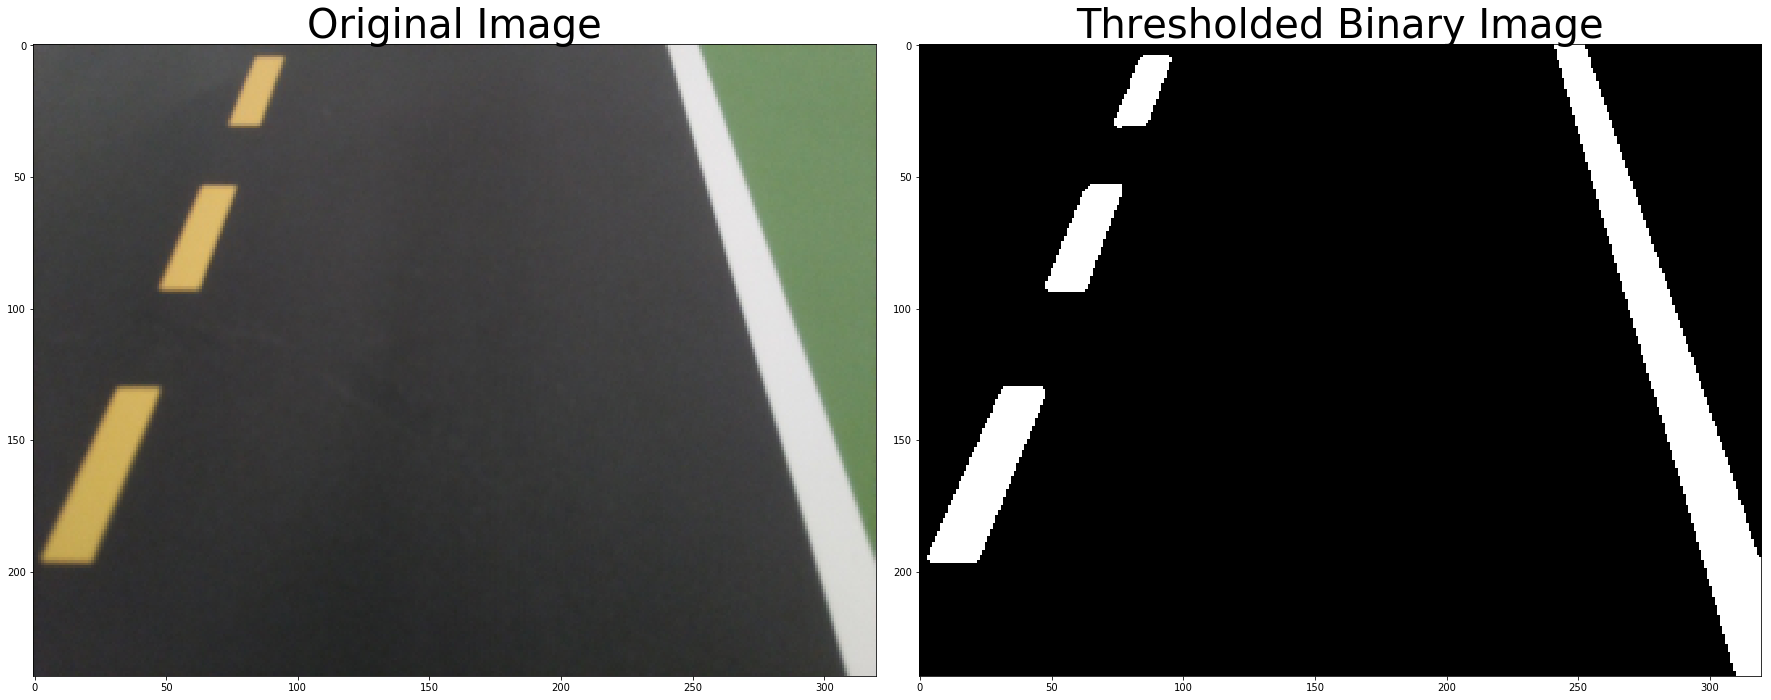

In [4]:
def pipeline_threshold2(img, h_thresh=(15, 100), s_thresh=(100, 255), sx_thresh=(50, 150)):
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 220
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    combined_binary = l_binary
    
    return combined_binary

import cv2
img = mpimg.imread('Raspi_images/image0002.jpg')
result = pipeline_threshold(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)

In [16]:
def perspective_transform(img):
    h,w = img.shape[:2]
    # Define 4 source points (which takes shape of trapezoid)
    rows, cols = img.shape[:2]
    
    #src = np.float32([[170, img.shape[0]], [550, 460], 
    #                  [745, 460], [1200, img.shape[0]]])
    
    #src = np.float32([[330, 300],[860, 300],
     #                 [1230, 720],[40, 720]])
    
    #src = np.float32([[30, 720],[340, 300],
    #                  [880, 300],[1200, 720]])
    
    src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.08],
                      [cols*0.8, rows*0.08],[cols*0.99, rows*0.98]])
    
    #bottom_left  = [cols*0.01, rows*0.98]
    #top_left     = [cols*0.1, rows*0.1]
    #bottom_right = [cols*0.99, rows*0.98]
    #top_right    = [cols*0.8, rows*0.1]
    
    # Define 4 destination points (which takes shape of rectangle)
    dst = np.float32([[100, img.shape[0]], [100, 0], 
                      [1100, 0], [1100, img.shape[0]]])
    
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    # 1. Distortion correction
    
    # 2. Perspective transformation
    src = np.float32([
        (696,455),    
        (587,455), 
        (235,700),  
        (1075,700)
    ])

    dst = np.float32([
        (xsize - 350, 0),
        (350, 0),
        (350, ysize),
        (xsize - 350, ysize)
    ])


    
    # Compute the perspective transform, M, given source and destination points.
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped

def display_unwarped(img, cmap='hsv'):
    result,_,_,src = perspective_transform(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(img, cmap=cmap)
    ax1.set_title('Original Image', fontsize=15)
    x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
    ax1.plot(x, y, color='#f75b44', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

    ax2.imshow(result, cmap=cmap)
    ax2.set_title('Unwarped Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

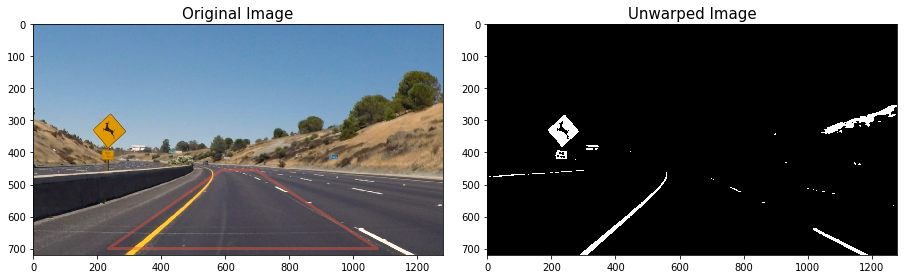

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib inline

img = mpimg.imread('test_images/test2.jpg')
import math
#Image without perspective transform
display_unwarped(img)
#Image with perspective transform
plt.imshow(pipeline_threshold(img), cmap='gray')

pranked


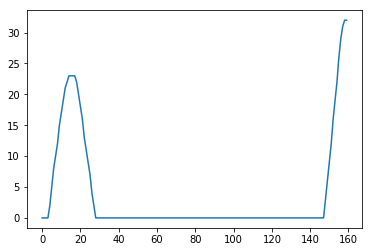

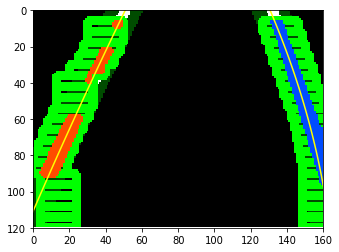

In [26]:
def create_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def sliding_window_polynomial_fit(binary_warped, show_image=True, nwindows = 19):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if show_image:
        print("pranked")
        # Print histogram from sliding window polyfit for example image
        plt.plot(histogram)
        plt.show()
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # print("histogram shape",histogram.shape)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    # print("leftx_base-",leftx_base)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print("rightx_base-",rightx_base)
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 10
    # Set minimum number of pixels found to recenter window
    minpix = 5
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if show_image:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    if left_fit is not None and right_fit is not None:
        # Generate x and y values for plotting
        ploty, left_fitx, right_fitx = create_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)
        
        if show_image:
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 160)
            plt.ylim(120, 0)

    return left_fit, right_fit

#img = mpimg.imread('test_images2/test2.jpg')
#img = "test_images2/test2.jpg"
#binary_warped = apply_thresholds(img, False)
#print(binary_warped.shape)

#binary_warped = perspective_transform_helper(pipeline_undistort_and_threshold(img))
#left_fit, right_fit = sliding_window_polynomial_fit(binary_warped)


img = mpimg.imread('NewTest/image0001.jpg')


#binary_warped = perspective_transform_helper(pipeline_threshold(img))
binary_warped = (pipeline_threshold(img))

left_fit, right_fit = sliding_window_polynomial_fit(binary_warped)

In [ ]:
def polynomialfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def get_curvature(width, ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    # 720 px is length of the lane 
    # 900 px is the average width of the lane
    # Note - The image under consideration is perspectively projected.
    # Calculate the radius of curvature
    # Reference - QA from udacity forums,
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 0.15/900 # meters per pixel in x dimension
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the radii of curvature
    radius_left_lane =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    radius_right_lane = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    # Vehicle position estimate depends on the road curving left or right.
    # This is because the polynomial evaluation happens at the top of the images,
    # instead of the bottom of the screen (where the car is): instead of 0, some value near 720 (height) is be used.
    car_position = width / 2
    #lane_center = (left_fitx[719] + right_fitx[719]) / 2
    lane_center = (left_fitx[359] + right_fitx[359]) / 2
    
    #Distance from the center lane
    vehicle_offset = (lane_center-car_position)*xm_per_pix
    
    # Radius of curvature is in meters is the average of the left and right radius.
    radius_of_curvature = np.mean([radius_left_lane, radius_right_lane])
    return radius_of_curvature, vehicle_offset

def draw_lane_quadrilateral(undist, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty, left_fitx, right_fitx = create_xy_for_plotting(warped.shape[0], left_fit, right_fit)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (128,0, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    print("vehicle_offset: ", vehicle_offset)
    print("radius_of_curvature", radius_of_curvature)
    show_radius_and_offset=True
    if show_radius_and_offset:
        font = cv2.FONT_HERSHEY_DUPLEX
        radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
        cv2.putText(result, "Lane Curve Radius(m): {0:0.2f}".format(radius_of_curvature),
                    (20,70), font, 2,(255,255,0),2, cv2.LINE_AA)
        cv2.putText(result, "Car offset(m): {0:0.2f}".format(vehicle_offset),
                    (20,130), font, 2,(255,255,0),2, cv2.LINE_AA)
    return result, left_fit, right_fit
    #return undist, left_fit, right_fit


# Final Pipleline function
# Distortion correction -> Combined threshold ->Perspective transform -> Detect lane lines ->
#Determine the lane curvature and draw lane area.
def pipeline_to_process_image(image, left_fit_prev=None, right_fit_prev=None):
    warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
    left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
    if left_fit is None or right_fit is None:
        left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=False)
    if left_fit is not None and right_fit is not None:
        return draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
    print("AAAAAAAAAAAAA")
    return image, left_fit, right_fit

In [ ]:
img = mpimg.imread('test_images2/test1.jpg')
#pipeline_to_process_image(img)

In [ ]:
fn, axes = plt.subplots(4, 2, figsize=(30, 25))
fn.subplots_adjust(hspace = .001, wspace=.001)
fn.tight_layout()

axes[0][0].set_title('Test Image 2', fontsize=10)
img = mpimg.imread('test_images2/test5.jpg')
result,_,_ = pipeline_to_process_image(img)
mpimg.imsave('Test1_Output.jpg', result)
axes[0][0].imshow(result)

In [ ]:
# reference - Udacity - Self Driving Car Nanodegree - PROJECT TIPS
class Lanes():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None

#Processing the project video
def process_video(input_path, output_path):
    # Reading video file
    video = VideoFileClip(input_path)
    lanes = Lanes()
    # The left and right fit will be saved and be used for the next image calculation.
    def process(image):
        output, left_fit, right_fit = pipeline_to_process_image(image, lanes.left_fit, lanes.right_fit)
        lanes.left_fit = left_fit
        lanes.right_fit = right_fit
        return output

    clip = video.fl_image(process)
    clip.write_videofile(output_path, audio=False)
    
#process_video('prank1.mp4', 'output.mp4')
process_video('prank1.mp4', 'output.mp4')


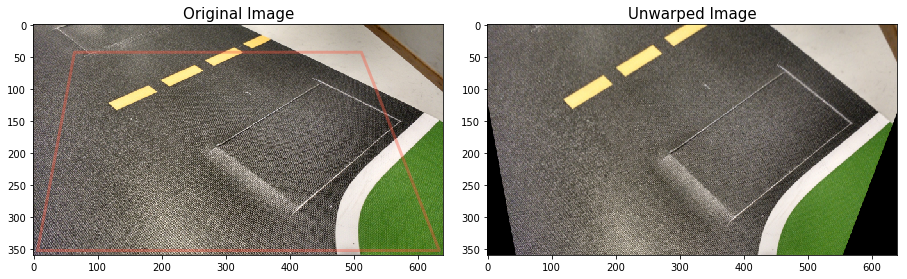

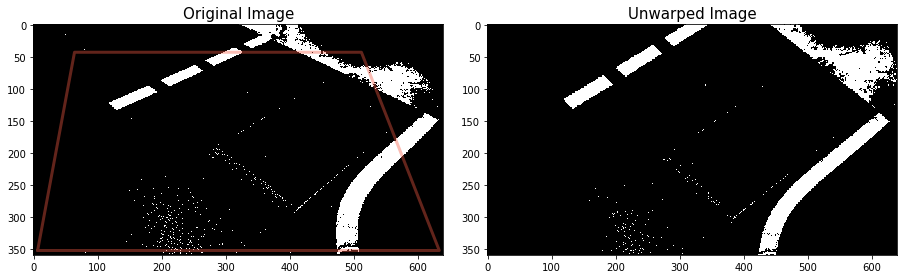

In [82]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from moviepy.editor import VideoFileClip
from collections import deque
#%matplotlib inline


def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):
    """
    Generate a thresholded binary image using transforms from an ensemble of color spaces:
    LAB (Yellow), HSV (Yellow + White), HLS (Yellow + White), RGB (White) and
    Adaptive Thresholding ()
    :param img (ndarray): Warped image
    :param visualise (boolean): Boolean flag for visualisation
    :return (ndarray): Thresholded binary image
    """

    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow

    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)

    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))

    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)

    ### Ensemble Voting

    #combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)
    #combined = np.asarray(R_binary + hls_binary, dtype=np.uint8)
    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary, dtype=np.uint8)

    combined[combined < 2] = 0
    combined[combined >= 2] = 1
    #kernel_size = 3
    #combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)
    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            #(adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]
    # Define 4 source points (which takes shape of trapezoid)
    #src = np.float32([[30, 720],[340, 300],
    #                  [880, 300],[1200, 720]])

    src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.12],
                      [cols*0.8, rows*0.12],[cols*0.99, rows*0.98]])

    #bottom_left  = [cols*0.01, rows*0.98]
    #top_left     = [cols*0.1, rows*0.1]
    #bottom_right = [cols*0.99, rows*0.98]
    #top_right    = [cols*0.8, rows*0.1]
    # Define 4 destination points (which takes shape of rectangle)
    #dst = np.float32([[100, img.shape[0]], [100, 0],
    #                  [1100, 0], [1100, img.shape[0]]])
    dst = np.float32([[50, img.shape[0]], [50, 0],
                      [550, 0], [550, img.shape[0]]])

    # Compute the perspective transform, M, given source and destination points.
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped

def display_unwarped(img, cmap='hsv'):
    result,_,_,src = perspective_transform(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(img, cmap=cmap)
    ax1.set_title('Original Image', fontsize=15)
    x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
    ax1.plot(x, y, color='#f75b44', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

    ax2.imshow(result, cmap=cmap)
    ax2.set_title('Unwarped Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

img = mpimg.imread('test_images2/test6.jpg')
#Image without perspective transform
display_unwarped(img)
#Image with perspective transform
display_unwarped(pipeline_threshold(img), cmap='gray')

a


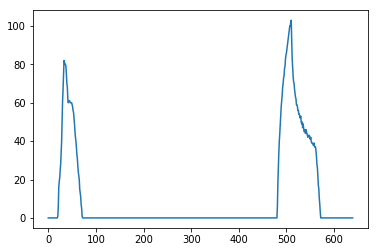

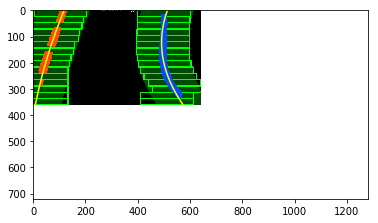

In [74]:
def create_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def sliding_window_polynomial_fit(binary_warped, show_image=True, nwindows = 15):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if show_image:
        # Print histogram from sliding window polyfit for example image
        plt.plot(histogram)
        print('a')
        plt.show()
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # print("histogram shape",histogram.shape)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    # print("leftx_base-",leftx_base)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print("rightx_base-",rightx_base)

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if show_image:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is not None and right_fit is not None:
        # Generate x and y values for plotting
        ploty, left_fitx, right_fitx = create_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)

        if show_image:
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)

    return left_fit, right_fit


img = mpimg.imread('test_images2/test9.jpg')
binary_warped = perspective_transform_helper(pipeline_threshold(img))
left_fit, right_fit = sliding_window_polynomial_fit(binary_warped)

In [80]:
def polynomialfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy +
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) +
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy +
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) +
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def get_curvature(width, ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    # 720 px is length of the lane
    # 900 px is the average width of the lane
    # Note - The image under consideration is perspectively projected.
    # Calculate the radius of curvature
    # Reference - QA from udacity forums,

    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 0.15/900 # meters per pixel in x dimension
    
    ym_per_pix = 0.6/600 # meters per pixel in y dimension
    xm_per_pix = 0.15/260 # meters per pixel in x dimension
    
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the radii of curvature
    radius_left_lane =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    radius_right_lane = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    # Vehicle position estimate depends on the road curving left or right.
    # This is because the polynomial evaluation happens at the top of the images,
    # instead of the bottom of the screen (where the car is): instead of 0, some value near 720 (height) is be used.
    car_position = width / 2
    #lane_center = (left_fitx[719] + right_fitx[719]) / 2
    lane_center = (left_fitx[359] + right_fitx[359]) / 2

    #Distance from the center lane
    vehicle_offset = (lane_center-car_position)*xm_per_pix

    # Radius of curvature is in meters is the average of the left and right radius.
    radius_of_curvature = np.mean([radius_left_lane, radius_right_lane])
    return radius_of_curvature, vehicle_offset

def draw_lane_quadrilateral(undist, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty, left_fitx, right_fitx = create_xy_for_plotting(warped.shape[0], left_fit, right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    
    return result, radius_of_curvature, vehicle_offset
    #return radius_of_curvature, vehicle_offset

    #show_radius_and_offset=False
    #if show_radius_and_offset:
    #    font = cv2.FONT_HERSHEY_DUPLEX

    #    cv2.putText(result, "Lane Curve Radius(m): {0:0.2f}".format(radius_of_curvature),
    #                (20,70), font, 2,(255,255,0),2, cv2.LINE_AA)
    #    cv2.putText(result, "Car offset(m): {0:0.2f}".format(vehicle_offset),
    #                (20,130), font, 2,(255,255,0),2, cv2.LINE_AA)
    #return result, left_fit, right_fit


# Final Pipleline function
# Distortion correction -> Combined threshold ->Perspective transform -> Detect lane lines ->
#Determine the lane curvature and draw lane area.
def pipeline_to_process_image(image, left_fit_prev=None, right_fit_prev=None):
    warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
    left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
    if left_fit is None or right_fit is None:
        left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=False)
    if left_fit is not None and right_fit is not None:
        return draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
    return image, left_fit, right_fit


img = mpimg.imread('test_images2/test7.jpg')
#result,_,_ = pipeline_to_process_image(img)
#result,curvature,offset = pipeline_to_process_image(img)
result, curvature,offset = pipeline_to_process_image(img)

#curvature, offset = pipeline_to_process_image(img)
print("vehicle_offset: ", offset)
print("radius_of_curvature", curvature)
cv2.imshow("result", result)
cv2.waitKey(0)
#print(type(result))
#print(result.size)

vehicle_offset:  -0.01504897343548077
radius_of_curvature 12.499859482786212


-1

In [53]:
img = mpimg.imread('test_images2/test7.jpg')
#result,_,_ = pipeline_to_process_image(img)
curvature, offset = pipeline_to_process_image(img)
#result,curvature,offset = pipeline_to_process_image(img)

print("vehicle_offset: ", offset)
print("radius_of_curvature", curvature)

vehicle_offset:  -0.02284805797055036
radius_of_curvature 13.165887856580825


In [63]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from moviepy.editor import VideoFileClip
from collections import deque
#%matplotlib inline


def binary_threshold(img, low, high):
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)

    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])

    output[mask] = 1
    return output

def pipeline_threshold(img, visualise=False):
    """
    Generate a thresholded binary image using transforms from an ensemble of color spaces:
    LAB (Yellow), HSV (Yellow + White), HLS (Yellow + White), RGB (White) and
    Adaptive Thresholding ()
    :param img (ndarray): Warped image
    :param visualise (boolean): Boolean flag for visualisation
    :return (ndarray): Thresholded binary image
    """

    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow

    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)

    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))

    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)

    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)

    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)

    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)

    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)

    ### Ensemble Voting

    #combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)
    #combined = np.asarray(R_binary + hls_binary, dtype=np.uint8)
    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary, dtype=np.uint8)

    combined[combined < 2] = 0
    combined[combined >= 2] = 1
    #kernel_size = 5
    #combined = cv2.GaussianBlur(combined, (kernel_size, kernel_size), 0)
    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            #(adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined

def perspective_transform(img):
    h,w = img.shape[:2]
    rows, cols = img.shape[:2]
    # Define 4 source points (which takes shape of trapezoid)
    #src = np.float32([[30, 720],[340, 300],
    #                  [880, 300],[1200, 720]])

    src = np.float32([[cols*0.01, rows*0.98],[cols*0.1, rows*0.08],
                      [cols*0.8, rows*0.08],[cols*0.99, rows*0.98]])

    #bottom_left  = [cols*0.01, rows*0.98]
    #top_left     = [cols*0.1, rows*0.1]
    #bottom_right = [cols*0.99, rows*0.98]
    #top_right    = [cols*0.8, rows*0.1]
    # Define 4 destination points (which takes shape of rectangle)
    #dst = np.float32([[100, img.shape[0]], [100, 0],
    #                  [1100, 0], [1100, img.shape[0]]])

    #dst = np.float32([[50, img.shape[0]], [50, 0],
    #                  [550, 0], [550, img.shape[0]]])

    dst = np.float32([[50, img.shape[0]], [50, 50],
                      [550, 50], [550, img.shape[0]]])
    # Compute the perspective transform, M, given source and destination points.
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv, src

def perspective_transform_helper(img):
    warped,_,_,_ = perspective_transform(img)
    return warped

def display_unwarped(img, cmap='hsv'):
    result,_,_,src = perspective_transform(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(img, cmap=cmap)
    ax1.set_title('Original Image', fontsize=15)
    x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
    y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
    ax1.plot(x, y, color='#f75b44', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

    ax2.imshow(result, cmap=cmap)
    ax2.set_title('Unwarped Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#img = mpimg.imread('test_images2/test2.jpg')
#Image without perspective transform
#display_unwarped(img)
#Image with perspective transform
#display_unwarped(pipeline_threshold(img), cmap='gray')


def create_xy_for_plotting(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def sliding_window_polynomial_fit(binary_warped, show_image=False, nwindows = 13):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if show_image:
        # Print histogram from sliding window polyfit for example image
        #plt.plot(histogram)
        print('a')
        #plt.show()
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # print("histogram shape",histogram.shape)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    # print("leftx_base-",leftx_base)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print("rightx_base-",rightx_base)

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if show_image:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is not None and right_fit is not None:
        # Generate x and y values for plotting
        ploty, left_fitx, right_fitx = create_xy_for_plotting(binary_warped.shape[0], left_fit, right_fit)

        if show_image:
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)

    return left_fit, right_fit


#img = mpimg.imread('test_images2/test7.jpg')
#binary_warped = perspective_transform_helper(pipeline_threshold(img))
#left_fit, right_fit = sliding_window_polynomial_fit(binary_warped)

def polynomialfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy +
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) +
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy +
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) +
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def get_curvature(width, ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    # 720 px is length of the lane
    # 900 px is the average width of the lane
    # Note - The image under consideration is perspectively projected.
    # Calculate the radius of curvature
    # Reference - QA from udacity forums,

    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 0.15/900 # meters per pixel in x dimension
    ym_per_pix = 0.5/600 # meters per pixel in y dimension
    xm_per_pix = 0.15/300 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the radii of curvature
    radius_left_lane =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    radius_right_lane = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    # Vehicle position estimate depends on the road curving left or right.
    # This is because the polynomial evaluation happens at the top of the images,
    # instead of the bottom of the screen (where the car is): instead of 0, some value near 720 (height) is be used.
    car_position = width / 2
    #lane_center = (left_fitx[719] + right_fitx[719]) / 2
    lane_center = (left_fitx[359] + right_fitx[359]) / 2

    #Distance from the center lane
    vehicle_offset = (lane_center-car_position)*xm_per_pix

    # Radius of curvature is in meters is the average of the left and right radius.
    radius_of_curvature = np.mean([radius_left_lane, radius_right_lane])
    return radius_of_curvature, vehicle_offset

def draw_lane_quadrilateral(undist, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty, left_fitx, right_fitx = create_xy_for_plotting(warped.shape[0], left_fit, right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    radius_of_curvature, vehicle_offset = get_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    return result, radius_of_curvature, vehicle_offset
    #return radius_of_curvature, vehicle_offset
    #show_radius_and_offset=False
    #if show_radius_and_offset:
    #    font = cv2.FONT_HERSHEY_DUPLEX

    #    cv2.putText(result, "Lane Curve Radius(m): {0:0.2f}".format(radius_of_curvature),
    #                (20,70), font, 2,(255,255,0),2, cv2.LINE_AA)
    #    cv2.putText(result, "Car offset(m): {0:0.2f}".format(vehicle_offset),
    #                (20,130), font, 2,(255,255,0),2, cv2.LINE_AA)
    #return result, left_fit, right_fit


# Final Pipleline function
# Distortion correction -> Combined threshold ->Perspective transform -> Detect lane lines ->
#Determine the lane curvature and draw lane area.
def pipeline_to_process_image(image, left_fit_prev=None, right_fit_prev=None):
    warped, _, Minv, _ = perspective_transform(pipeline_threshold(image))
    left_fit, right_fit = polynomialfit_from_previous(warped, left_fit_prev, right_fit_prev)
    if left_fit is None or right_fit is None:
        left_fit, right_fit = sliding_window_polynomial_fit(warped, show_image=False)
    if left_fit is not None and right_fit is not None:
        return draw_lane_quadrilateral(image, warped, Minv, left_fit, right_fit)
    print("prank")
    return image, left_fit, right_fit


img = mpimg.imread('test_images2/test9.jpg')
#result,_,_ = pipeline_to_process_image(img)
result, curvature, offset = pipeline_to_process_image(img)
#result,curvature,offset = pipeline_to_process_image(img)

print("vehicle_offset: ", offset)
print("radius_of_curvature", curvature)
cv2.imshow("result", result)
cv2.waitKey(0)
#print(type(result))
#print(result.size)

vehicle_offset:  -0.008975432394440703
radius_of_curvature 0.47876235518409493


-1